# Analyze suspended MDCK for supp 1

## Libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd

from skimage.measure import regionprops_table, marching_cubes, mesh_surface_area
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border
from skimage.filters import unsharp_mask
from skimage.color import label2rgb

from cellpose import models, core
from cellpose import plot

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();

2023-07-05 17:14:28,038 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1
2023-07-05 17:14:28,040 [INFO] WRITING LOG OUTPUT TO /home/minato/.cellpose/run.log


## Functions

In [1]:
def segment(data_name, suffix):
    res = []
    for s in suffix:
        print(s)
        img = np.load(f'../result/{data_name}{s}.npy')
        img = img[10:60, 10:630, 27: img.shape[2]-27]
        img = (img - img.min()) / (img.max() - img.min())
        img = unsharp_mask(img, radius=5, amount=10)

        model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
        channels = [0,0]
        masks, flows, styles, _ = model.eval(img, channels=channels, diameter=17, do_3D=True)
        res.append(masks)

    return res

In [3]:
def set_scalebar(ax, size, x_scale, vsize=2, borderpad=1, loc='lower right'):
    '''
    size: size in micrometers
    vsize: width of scale bar
    borderpad: distance of scale bar to edge of image
    '''
    scalebar = AnchoredSizeBar(ax.transData, size=size/x_scale, label='',
                               loc=loc, frameon=False, color='white', size_vertical=vsize, borderpad=borderpad, label_top=True,
                               fontproperties=fm.FontProperties(size=12))
    ax.add_artist(scalebar)

## Analysis

In [5]:
data = 'id551_MDCK_cellonly_01_300Hz_405_250mW_488_150mW_405'
suffix = ['']

In [6]:
res = segment(data, suffix)


2023-07-05 17:10:08,273 [INFO] ** TORCH CUDA version installed and working. **
2023-07-05 17:10:08,275 [INFO] >>>> using GPU
2023-07-05 17:10:08,277 [INFO] >> nuclei << model set to be used
2023-07-05 17:10:08,430 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2023-07-05 17:10:08,432 [INFO] ~~~ FINDING MASKS ~~~
2023-07-05 17:10:08,498 [INFO] multi-stack tiff read in as having 50 planes 1 channels
2023-07-05 17:10:15,279 [INFO] running YX: 50 planes of size (620, 2736)
2023-07-05 17:10:48,400 [INFO] 100%|##########| 50/50 [00:32<00:00,  1.53it/s]
2023-07-05 17:10:51,456 [INFO] running ZY: 620 planes of size (50, 2736)
2023-07-05 17:11:27,832 [INFO] 100%|##########| 310/310 [00:35<00:00,  8.67it/s]
2023-07-05 17:11:32,286 [INFO] running ZX: 2736 planes of size (50, 620)
2023-07-05 17:12:14,366 [INFO] 100%|##########| 342/342 [00:41<00:00,  8.26it/s]
2023-07-05 17:12:20,610 [INFO] network run in 131.28s
2023-07-05 17:14:14,175 [INFO] masks created in 

In [7]:
for i in res:
    print(np.unique(i))

[   0    1    2 ... 3512 3513 3514]


In [8]:
img = np.load('../result/id551_MDCK_cellonly_01_300Hz_405_250mW_488_150mW_405.npy')
img = (img - img.min()) / (img.max() - img.min())
img = img[10:60, 10:630, 27: img.shape[2]-27]

In [9]:
img.shape

(50, 620, 2736)

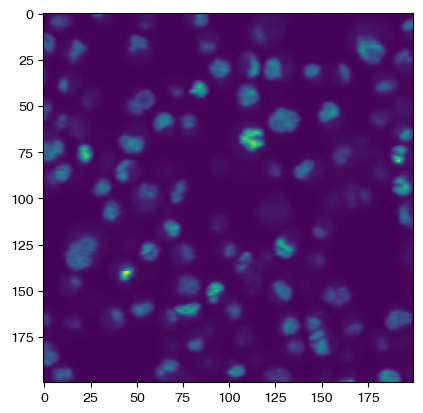

In [10]:
plt.imshow(img[25, 200:400, 500:700])

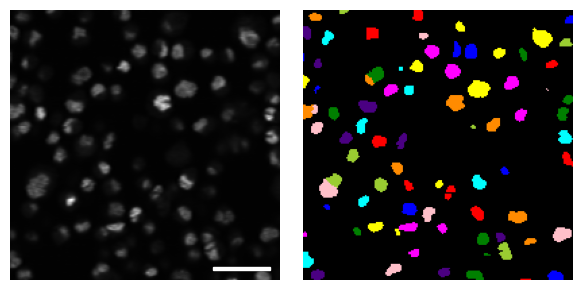

In [16]:
color = label2rgb(res[0][25, 200:400, 500:700])

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img[25, 200:400, 500:700], cmap='gray')
axes[0].axis('off')
set_scalebar(axes[0], size=50, x_scale=1.18, vsize=2, borderpad=0.5, loc='lower right')

axes[1].imshow(color)
axes[1].axis('off')

plt.tight_layout()

plt.savefig('../result/segmented_nuclei-suspended.pdf', bbox_inches='tight', pad_inches=0.05)